In [1]:
# Importing all the tools we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline 

# Modles from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Model evaluations
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import plot_roc_curve

from joblib import dump,load

In [2]:
# Make by default all fig sized 10 ,6
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
# Import Data with parsing dates
df = pd.read_csv('Data/TrainAndValid.csv',
                low_memory = False,
                parse_dates=["saledate"])
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


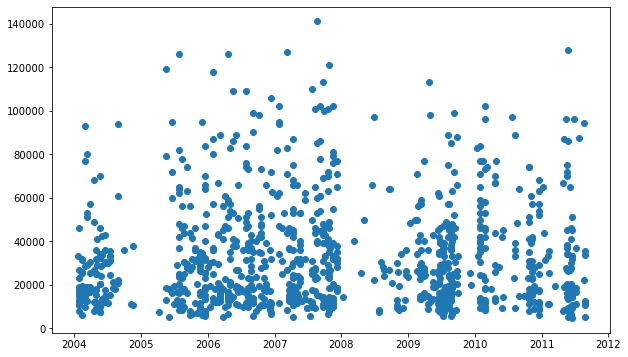

In [4]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

In [5]:
# Make a copy of the original dataframe
df_tmp = df.copy()

In [6]:
# Sort DataFrame by date order
df_tmp.sort_values(by=["saledate"],inplace=True, ascending=True)
df_tmp.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [7]:
def preprocess_data(df):
    """"
    Performes transofrmation on data frame and returnes transofmed dataframe
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate",axis = 1, inplace=True)
    #Turn all string values into category values
    for label,content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            
    # Fill the numeric rows with the median
    for label , content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df["lavel"+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric row with median
                df[label] = content.fillna(content.median())
                
        #Filled categorical missing data and turn categories into numbers        
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add + 1 to the category code because pandas encodes
            # missing data into 0
            df[label] = pd.Categorical(content).codes + 1
            
    return df
      

### Create an evaluation function 

In [8]:

from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score

def rmsle(y_test,y_preds):
    """
    Calculates the root mean squared log error between predicted
    and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    # If train preds has negative values make them positive
    for index,item in enumerate(train_preds):
        if item < 0 :
            train_preds[index] = train_preds[index] * -1

        
    # If valid preds has negative values make them positive
    for index,item in enumerate(val_preds):
        if item < 0:
            val_preds[index] = val_preds[index] * -1
    
    scores ={"Training MAE":mean_absolute_error(y_train,train_preds),
            "Valid MAE":mean_absolute_error(y_valid,val_preds),
            "Training RMSLE":rmsle(y_train,train_preds),
            "Valid RMSLE":rmsle(y_valid,val_preds),
            "Training R^2":r2_score(y_train,train_preds),
            "Valid R^2":r2_score(y_valid,val_preds)}
    return scores

In [9]:
df_tmp = preprocess_data(df_tmp)


In [10]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

In [11]:
#Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]
len(df_val),len(df_train)

(11573, 401125)

In [12]:
# Split data into X and y
X_train,y_train = df_train.drop("SalePrice",axis=1), df_train.SalePrice
X_valid,y_valid = df_val.drop("SalePrice",axis=1), df_val.SalePrice

In [13]:
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 101), (401125,), (11573, 101), (11573,))

In [14]:
%%time 
from sklearn.ensemble import RandomForestRegressor
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5)

ideal_model.fit(X_train,y_train)

CPU times: user 2min 5s, sys: 547 ms, total: 2min 5s
Wall time: 2min 5s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40)

In [15]:
show_scores(ideal_model)

{'Training MAE': 2958.153101949735,
 'Valid MAE': 5934.7390352785515,
 'Training RMSLE': 0.14482186272629533,
 'Valid RMSLE': 0.24457471907472053,
 'Training R^2': 0.9587208458247314,
 'Valid R^2': 0.8825157324236707}

In [16]:
ideal_model.score(X_valid,y_valid)

0.8825157324236707

In [17]:
df_test = pd.read_csv("Data/Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [18]:
df_test = preprocess_data(df_test)
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [19]:
test_preds = ideal_model.predict(df_test)

In [20]:
test_preds

array([17688.31637709, 15791.59429162, 48937.27277216, ...,
       14767.6707953 , 16698.56217993, 29778.96918385])

In [21]:
%%time
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor()

cat_model.fit(X_train,y_train)

Learning rate set to 0.113445
0:	learn: 21728.2511168	total: 93.3ms	remaining: 1m 33s
1:	learn: 20591.1111758	total: 131ms	remaining: 1m 5s
2:	learn: 19685.9300949	total: 166ms	remaining: 55.2s
3:	learn: 18867.8504772	total: 201ms	remaining: 50.1s
4:	learn: 18189.7033648	total: 236ms	remaining: 46.9s
5:	learn: 17635.6234403	total: 269ms	remaining: 44.5s
6:	learn: 17073.3649509	total: 302ms	remaining: 42.9s
7:	learn: 16666.5941573	total: 331ms	remaining: 41.1s
8:	learn: 16226.4254112	total: 363ms	remaining: 40s
9:	learn: 15829.0339283	total: 403ms	remaining: 39.9s
10:	learn: 15497.5176262	total: 437ms	remaining: 39.3s
11:	learn: 15228.5417760	total: 466ms	remaining: 38.4s
12:	learn: 14904.2472330	total: 500ms	remaining: 38s
13:	learn: 14668.3997658	total: 535ms	remaining: 37.7s
14:	learn: 14454.5174930	total: 567ms	remaining: 37.2s
15:	learn: 14214.2020037	total: 601ms	remaining: 36.9s
16:	learn: 13986.2690019	total: 635ms	remaining: 36.7s
17:	learn: 13814.4878869	total: 667ms	remaining

156:	learn: 9071.3220688	total: 5.09s	remaining: 27.3s
157:	learn: 9061.7894736	total: 5.12s	remaining: 27.3s
158:	learn: 9049.2013624	total: 5.16s	remaining: 27.3s
159:	learn: 9039.3276493	total: 5.19s	remaining: 27.2s
160:	learn: 9031.3301810	total: 5.22s	remaining: 27.2s
161:	learn: 9023.2087503	total: 5.25s	remaining: 27.2s
162:	learn: 9014.3491549	total: 5.28s	remaining: 27.1s
163:	learn: 9007.1584823	total: 5.32s	remaining: 27.1s
164:	learn: 8997.9204572	total: 5.36s	remaining: 27.1s
165:	learn: 8990.5726499	total: 5.39s	remaining: 27.1s
166:	learn: 8986.1180201	total: 5.42s	remaining: 27s
167:	learn: 8977.6154497	total: 5.46s	remaining: 27s
168:	learn: 8967.6435814	total: 5.49s	remaining: 27s
169:	learn: 8958.5278368	total: 5.52s	remaining: 26.9s
170:	learn: 8949.3271497	total: 5.55s	remaining: 26.9s
171:	learn: 8944.3254549	total: 5.58s	remaining: 26.9s
172:	learn: 8937.9378501	total: 5.62s	remaining: 26.9s
173:	learn: 8929.6430890	total: 5.65s	remaining: 26.8s
174:	learn: 8919

307:	learn: 8239.0807205	total: 10s	remaining: 22.5s
308:	learn: 8233.7795140	total: 10s	remaining: 22.4s
309:	learn: 8231.2260742	total: 10.1s	remaining: 22.4s
310:	learn: 8228.6593715	total: 10.1s	remaining: 22.4s
311:	learn: 8225.0348322	total: 10.1s	remaining: 22.3s
312:	learn: 8221.4118761	total: 10.2s	remaining: 22.3s
313:	learn: 8218.4402293	total: 10.2s	remaining: 22.3s
314:	learn: 8215.3224271	total: 10.2s	remaining: 22.2s
315:	learn: 8212.5950227	total: 10.2s	remaining: 22.2s
316:	learn: 8209.1938989	total: 10.3s	remaining: 22.2s
317:	learn: 8206.1360261	total: 10.3s	remaining: 22.1s
318:	learn: 8201.1639974	total: 10.4s	remaining: 22.1s
319:	learn: 8198.5037972	total: 10.4s	remaining: 22.1s
320:	learn: 8193.6757747	total: 10.4s	remaining: 22s
321:	learn: 8191.1681152	total: 10.5s	remaining: 22s
322:	learn: 8186.9078922	total: 10.5s	remaining: 22s
323:	learn: 8184.7294984	total: 10.5s	remaining: 21.9s
324:	learn: 8180.6728338	total: 10.6s	remaining: 21.9s
325:	learn: 8177.774

458:	learn: 7857.0695924	total: 14.8s	remaining: 17.5s
459:	learn: 7855.5570869	total: 14.9s	remaining: 17.5s
460:	learn: 7854.0850983	total: 14.9s	remaining: 17.4s
461:	learn: 7851.3050009	total: 14.9s	remaining: 17.4s
462:	learn: 7847.6725714	total: 15s	remaining: 17.4s
463:	learn: 7845.9396056	total: 15s	remaining: 17.3s
464:	learn: 7844.7039674	total: 15s	remaining: 17.3s
465:	learn: 7842.8922977	total: 15.1s	remaining: 17.3s
466:	learn: 7841.8113635	total: 15.1s	remaining: 17.2s
467:	learn: 7839.3654951	total: 15.1s	remaining: 17.2s
468:	learn: 7837.0324013	total: 15.2s	remaining: 17.2s
469:	learn: 7834.1391020	total: 15.2s	remaining: 17.1s
470:	learn: 7831.9812031	total: 15.2s	remaining: 17.1s
471:	learn: 7829.6971299	total: 15.3s	remaining: 17.1s
472:	learn: 7828.8818808	total: 15.3s	remaining: 17s
473:	learn: 7827.0802107	total: 15.3s	remaining: 17s
474:	learn: 7826.2319087	total: 15.3s	remaining: 17s
475:	learn: 7824.8044723	total: 15.4s	remaining: 16.9s
476:	learn: 7823.81925

611:	learn: 7612.8388676	total: 19.7s	remaining: 12.5s
612:	learn: 7611.4721874	total: 19.8s	remaining: 12.5s
613:	learn: 7610.3108274	total: 19.8s	remaining: 12.4s
614:	learn: 7608.8302163	total: 19.8s	remaining: 12.4s
615:	learn: 7607.6891267	total: 19.9s	remaining: 12.4s
616:	learn: 7606.8600863	total: 19.9s	remaining: 12.3s
617:	learn: 7605.2682166	total: 19.9s	remaining: 12.3s
618:	learn: 7604.1584077	total: 19.9s	remaining: 12.3s
619:	learn: 7602.8349129	total: 20s	remaining: 12.2s
620:	learn: 7601.2367520	total: 20s	remaining: 12.2s
621:	learn: 7600.4309182	total: 20s	remaining: 12.2s
622:	learn: 7599.1556763	total: 20.1s	remaining: 12.1s
623:	learn: 7597.4429932	total: 20.1s	remaining: 12.1s
624:	learn: 7596.6993488	total: 20.1s	remaining: 12.1s
625:	learn: 7594.8201253	total: 20.2s	remaining: 12s
626:	learn: 7593.2325661	total: 20.2s	remaining: 12s
627:	learn: 7591.9802746	total: 20.2s	remaining: 12s
628:	learn: 7591.0054828	total: 20.3s	remaining: 12s
629:	learn: 7588.9682492

763:	learn: 7432.0688192	total: 24.6s	remaining: 7.58s
764:	learn: 7431.2840314	total: 24.6s	remaining: 7.55s
765:	learn: 7429.8942100	total: 24.6s	remaining: 7.52s
766:	learn: 7428.3084319	total: 24.6s	remaining: 7.49s
767:	learn: 7427.5772078	total: 24.7s	remaining: 7.45s
768:	learn: 7426.7436857	total: 24.7s	remaining: 7.42s
769:	learn: 7425.7495748	total: 24.7s	remaining: 7.39s
770:	learn: 7424.5993092	total: 24.8s	remaining: 7.36s
771:	learn: 7424.0437566	total: 24.8s	remaining: 7.32s
772:	learn: 7422.4257659	total: 24.8s	remaining: 7.29s
773:	learn: 7421.5786325	total: 24.9s	remaining: 7.26s
774:	learn: 7420.9220265	total: 24.9s	remaining: 7.22s
775:	learn: 7420.0230879	total: 24.9s	remaining: 7.19s
776:	learn: 7419.2555576	total: 24.9s	remaining: 7.16s
777:	learn: 7418.0880863	total: 25s	remaining: 7.13s
778:	learn: 7417.3322087	total: 25s	remaining: 7.09s
779:	learn: 7416.0784519	total: 25s	remaining: 7.06s
780:	learn: 7414.8706372	total: 25.1s	remaining: 7.03s
781:	learn: 7413

915:	learn: 7289.8171796	total: 29.4s	remaining: 2.69s
916:	learn: 7289.1328405	total: 29.4s	remaining: 2.66s
917:	learn: 7288.6041804	total: 29.4s	remaining: 2.63s
918:	learn: 7287.3713277	total: 29.5s	remaining: 2.6s
919:	learn: 7286.4933801	total: 29.5s	remaining: 2.56s
920:	learn: 7286.0523143	total: 29.5s	remaining: 2.53s
921:	learn: 7285.6410629	total: 29.6s	remaining: 2.5s
922:	learn: 7285.0445993	total: 29.6s	remaining: 2.47s
923:	learn: 7284.1029576	total: 29.6s	remaining: 2.44s
924:	learn: 7283.2128359	total: 29.7s	remaining: 2.4s
925:	learn: 7282.6135229	total: 29.7s	remaining: 2.37s
926:	learn: 7281.9762985	total: 29.7s	remaining: 2.34s
927:	learn: 7280.7745960	total: 29.8s	remaining: 2.31s
928:	learn: 7279.8317682	total: 29.8s	remaining: 2.28s
929:	learn: 7279.0202497	total: 29.8s	remaining: 2.25s
930:	learn: 7277.8719353	total: 29.9s	remaining: 2.21s
931:	learn: 7277.5319831	total: 29.9s	remaining: 2.18s
932:	learn: 7276.7641831	total: 29.9s	remaining: 2.15s
933:	learn: 7

In [22]:
show_scores(cat_model)

{'Training MAE': 4770.135795882376,
 'Valid MAE': 6145.599626149674,
 'Training RMSLE': 0.23892949274936745,
 'Valid RMSLE': 0.25967043225279307,
 'Training R^2': 0.9016390665854933,
 'Valid R^2': 0.8776685934850866}

In [ ]:
%%time
# Hyper parameter tuning with RanomizedSearchCV
# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators":np.arange(10,100,10),
           "max_depth":[None,3,5,10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2),
           "max_features":[0.5,1,"sqrt","auto"]}

# Instantiate Randomized Search CV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

#Fit the randomized searchcv model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
show_scores(rs_model)